In [11]:
!pip uninstall statsmodels -y


Uninstalling statsmodels-0.10.2:
  Successfully uninstalled statsmodels-0.10.2


In [12]:
pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-spxcgds9
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-spxcgds9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+2.g54f7c05be-cp36-cp36m-linux_x86_64.whl size=17705131 sha256=742e45629fb882e654ea75fba92e2b4f857cb188f6a6c5cffb14ab45e019dc93
  Stored in directory: /tmp/pip-ephem-wheel-cache-xzb9zt_g/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pywt

from itertools import islice
from collections import deque

from tensorflow.python.keras.layers import Input, Dense,RNN,LSTMCell
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.losses import mean_absolute_percentage_error,mae

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import statespace

from pandas.plotting import autocorrelation_plot

from datetime import datetime
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mae(A,F):
    return np.mean(np.abs(A -F))

def get_family(wave):
  if 'bior' in wave:
    return 'bior'
  elif 'coif' in wave:
    return 'coif'
  elif 'db' in wave:
    return 'db'
  elif 'dmey' in wave:
    return 'dmey'
  elif 'rbio' in wave:
    return 'rbio'
  elif 'sym' in wave:
    return 'sym'
  else:
    return 'haar'

def denoise(original,WAVELET):

  signal = original.values

  coeffs = pywt.wavedec(signal, WAVELET)
  coeffs[1:] = (pywt.threshold(detail,
                              value=0.5 * np.std(detail), 
                              mode="soft" ) for detail in coeffs[1:])
  reconstructed_signal = pywt.waverec(coeffs, WAVELET)
  return pd.Series(reconstructed_signal[:-1],index=original.index)


def window(seq, n=4):
  it = iter(seq)
  result = tuple(islice(it, n))
  if len(result) == n:
    yield np.array(result)
  for elem in it:
    result = result[1:] + (elem,)
    yield np.array(result)

def percentage_scaler(signal,low=0,high=100):
  minV = np.min(signal)
  maxV = np.max(signal)
  denom = maxV - minV

  scaled_signal = low + ((signal - minV )* (high-low)) / denom 

  return round(scaled_signal)

def get_label(x):
  if x == 0.0:
    return 'ZERO'
  elif x < SCALE_UP_WATER_MARK:
    return 'STAY'
  else :
    return 'SCALE UP'

In [3]:
SCALE_UP_WATER_MARK = 10

In [4]:
df = pd.read_csv('winProxy.csv',parse_dates=True,index_col=0)
original = df.CPU
df['smooth_CPU'] = denoise(original,'db38')

df.diskwrite = df.diskwrite.shift(periods=1)
df.diskwrite = df.diskwrite.fillna(0)
#df[["CPU","diskwrite"]].tail()

df.IOBalance = df.IOBalance.shift(periods=1)
df.IOBalance = df.IOBalance.fillna(0)

train_size = round(len(df) * 0.8)
Y_test = original[train_size:].values
Y_test_labels = [get_label(x) for x in Y_test]

# AR

In [77]:
ar_forecast = []
training_endog = df.CPU.values[:train_size]
mod = sm.tsa.statespace.SARIMAX(training_endog, 
                          order=(3,0,0))

res = mod.fit()
val = np.maximum(0,res.forecast()[0])
ar_forecast.append(round(val))

In [78]:

for i in range(0,len(df)-train_size):
  res = res.extend(df.CPU.values[train_size+i:train_size+i+1])
  val = np.maximum(0,res.forecast()[0])
  ar_forecast.append(round(val))

ar_forecast = np.array(ar_forecast)[:-1]

In [79]:
print("MAPE : ",mape(Y_test+1,ar_forecast+1))
print("SMAPE : ",smape(Y_test+1,ar_forecast+1))
print("MAE : ",mae(Y_test+1,ar_forecast+1))

MAPE :  7.3358471019542115
SMAPE :  5.503462565944924
MAE :  0.3678755144031635


In [80]:
ar_test_labels = [get_label(x) for x in ar_forecast]

print(classification_report(Y_test_labels,ar_test_labels))
confusion_matrix(Y_test_labels,ar_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.25      0.21      0.23        19
        STAY       0.95      0.98      0.96       756
        ZERO       0.99      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.73      0.72      0.73      2592
weighted avg       0.98      0.98      0.98      2592



array([[   4,   12,    3],
       [  12,  738,    6],
       [   0,   27, 1790]])

# MA

In [102]:
ma_forecast = []
training_endog = df.CPU.values[:train_size]
mod = sm.tsa.statespace.SARIMAX(training_endog, 
                          order=(0,0,12))

res = mod.fit()
val = np.maximum(0,res.forecast()[0])
ma_forecast.append(round(val))

In [103]:

for i in range(0,len(df)-train_size):
  res = res.extend(df.CPU.values[train_size+i:train_size+i+1])
  val = np.maximum(0,res.forecast()[0])
  ma_forecast.append(round(val))

ma_forecast = np.array(ma_forecast)[:-1]

In [104]:
print("MAPE : ",mape(Y_test+1,ma_forecast+1))
print("SMAPE : ",smape(Y_test+1,ma_forecast+1))
print("MAE : ",mae(Y_test+1,ma_forecast+1))

MAPE :  9.127536222996472
SMAPE :  8.30727301484553
MAE :  0.48091563785995367


In [105]:
ma_test_labels = [get_label(x) for x in ma_forecast]

print(classification_report(Y_test_labels,ma_test_labels))
confusion_matrix(Y_test_labels,ma_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.27      0.21      0.24        19
        STAY       0.96      0.97      0.97       756
        ZERO       0.99      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.74      0.73      0.73      2592
weighted avg       0.98      0.98      0.98      2592



array([[   4,   12,    3],
       [  11,  736,    9],
       [   0,   16, 1801]])

# ARMA

In [127]:
arma_forecast = []
training_endog = df.CPU.values[:train_size]
mod = sm.tsa.statespace.SARIMAX(training_endog, 
                          order=(4,0,4))

res = mod.fit()
val = np.maximum(0,res.forecast()[0])
arma_forecast.append(round(val))

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [128]:

for i in range(0,len(df)-train_size):
  res = res.extend(df.CPU.values[train_size+i:train_size+i+1])
  val = np.maximum(0,res.forecast()[0])
  arma_forecast.append(round(val))

arma_forecast = np.array(arma_forecast)[:-1]

In [129]:
print("MAPE : ",mape(Y_test+1,arma_forecast+1))
print("SMAPE : ",smape(Y_test+1,arma_forecast+1))
print("MAE : ",mae(Y_test+1,arma_forecast+1))

MAPE :  8.936535518180477
SMAPE :  6.510509046315533
MAE :  0.36586934156365736


In [130]:
arma_test_labels = [get_label(x) for x in arma_forecast]

print(classification_report(Y_test_labels,arma_test_labels))
confusion_matrix(Y_test_labels,arma_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.29      0.21      0.24        19
        STAY       0.90      0.98      0.94       756
        ZERO       1.00      0.96      0.98      1817

    accuracy                           0.96      2592
   macro avg       0.73      0.72      0.72      2592
weighted avg       0.96      0.96      0.96      2592



array([[   4,   12,    3],
       [  10,  741,    5],
       [   0,   74, 1743]])

# Visualizing forecasts

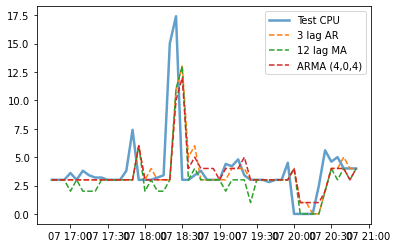

In [131]:
test_index = original[train_size:].index

#labs = ['12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
fig,ax = plt.subplots()
#ax.set_xticklabels(labs)
#ax.set_ylim(0,15)

# imp: 0,50 200,250 300,350 750,800 870,900
start = 200
end = 250
_ = ax.plot(pd.Series(Y_test[start:end],index = test_index[start:end]),linewidth=2.5,label='Test CPU',alpha=0.7)
#_ = ax.plot(pd.Series(rw_forecast[start:end],index = test_index[start:end]),linewidth=1,linestyle='dotted',label = 'RW')
#_ = ax.plot(pd.Series(arima_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = 'Exog ARIMA (3,1,6) ')
_ = ax.plot(pd.Series(ar_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = '3 lag AR')
_ = ax.plot(pd.Series(ma_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = '12 lag MA')
_ = ax.plot(pd.Series(arma_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = 'ARMA (4,0,4)')
#_ = ax.plot(pd.Series(ann_forecast[start:end] ,index = test_index[start:end]),linewidth=2,alpha=0.5, label = 'Proposed')

plt.legend()#loc='upper left'

plt.show()